In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

In [3]:
from gap_statistic import OptimalK
from sklearn import cluster
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn.decomposition import PCA

In [24]:
# colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# Generate 50 random integers between 0 and 0xFFFFFF (inclusive)
hex_values = np.random.randint(0, 0xFFFFFF, size=50)


# Create a list of 50 hex strings, where each string is prefixed with a '#' character,
# and has a length of 6 characters by filling with leading zeros.
hex_strings = ['#' + hex(x)[2:].zfill(6) for x in hex_values]

# Convert the list of hex strings to a NumPy array.
colors = np.array(hex_strings)



def clustering_scatterplot(points, labels, centers, title):
    fig, ax = plt.subplots(figsize=(15, 15))  # Increase the figure size here

    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = ax.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label='cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    ax.set_title(title)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [5]:
# Load the data
data = pd.read_csv('loans_train_prepared.csv')

In [6]:
# Create a PCA object with desired number of components
pca = PCA()

# Fit the data to the PCA model
pca.fit(data)

# Get the explained variance ratios of each component
variance_ratios = pca.explained_variance_ratio_

In [7]:
# Print the percentage variance explained by each principal component
for i, ratio in enumerate(variance_ratios):
    print(f"Principal Component {i+1}: {ratio*100:.2f}% variance")

Principal Component 1: 19.30% variance
Principal Component 2: 16.99% variance
Principal Component 3: 13.30% variance
Principal Component 4: 12.06% variance
Principal Component 5: 7.26% variance
Principal Component 6: 6.06% variance
Principal Component 7: 5.03% variance
Principal Component 8: 4.64% variance
Principal Component 9: 4.13% variance
Principal Component 10: 3.22% variance
Principal Component 11: 2.62% variance
Principal Component 12: 2.21% variance
Principal Component 13: 1.38% variance
Principal Component 14: 0.82% variance
Principal Component 15: 0.77% variance
Principal Component 16: 0.22% variance


In [9]:
percentage = 0
# Print the percentage variance captured with n number of components
for i, ratio in enumerate(variance_ratios):
    percentage += ratio
    print(f"Percentage captured with {i+1} component: {percentage*100:.2f}%")

Percentage captured with 1 component: 19.30%
Percentage captured with 2 component: 36.29%
Percentage captured with 3 component: 49.59%
Percentage captured with 4 component: 61.65%
Percentage captured with 5 component: 68.91%
Percentage captured with 6 component: 74.96%
Percentage captured with 7 component: 80.00%
Percentage captured with 8 component: 84.64%
Percentage captured with 9 component: 88.76%
Percentage captured with 10 component: 91.98%
Percentage captured with 11 component: 94.60%
Percentage captured with 12 component: 96.81%
Percentage captured with 13 component: 98.18%
Percentage captured with 14 component: 99.01%
Percentage captured with 15 component: 99.78%
Percentage captured with 16 component: 100.00%


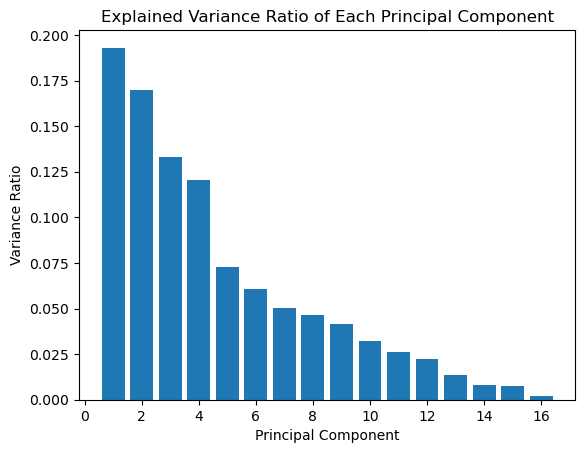

In [10]:
# Create a bar plot to visualize the variance ratios
plt.bar(range(1, len(variance_ratios)+1), variance_ratios)
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.show()


In [12]:
# 7 components were selected as they would contain 80%
# of the variance in all the data
pca_2 = PCA(n_components=7)
pca_2.fit(data)
data_transformed = pca_2.transform(data)

In [13]:
# Fit the KMeans model for k values ranging from 1 to 614
# The entire range of the data was used when trying 
# to find the optimal k value
k_range = range(1, len(data_transformed))

# Initialize an empty list to store the sum of squared distances for each value of k
sum_of_squared_distances = []

# Iterate over each value of k
for k in k_range:
    # Create a KMeans instance with k clusters and 'auto' initialization
    km = KMeans(n_clusters=k, n_init='auto')

    # Fit the KMeans model to the data
    km.fit(data_transformed)

    # Calculate and append the sum of squared distances to the list
    sum_of_squared_distances.append(km.inertia_)

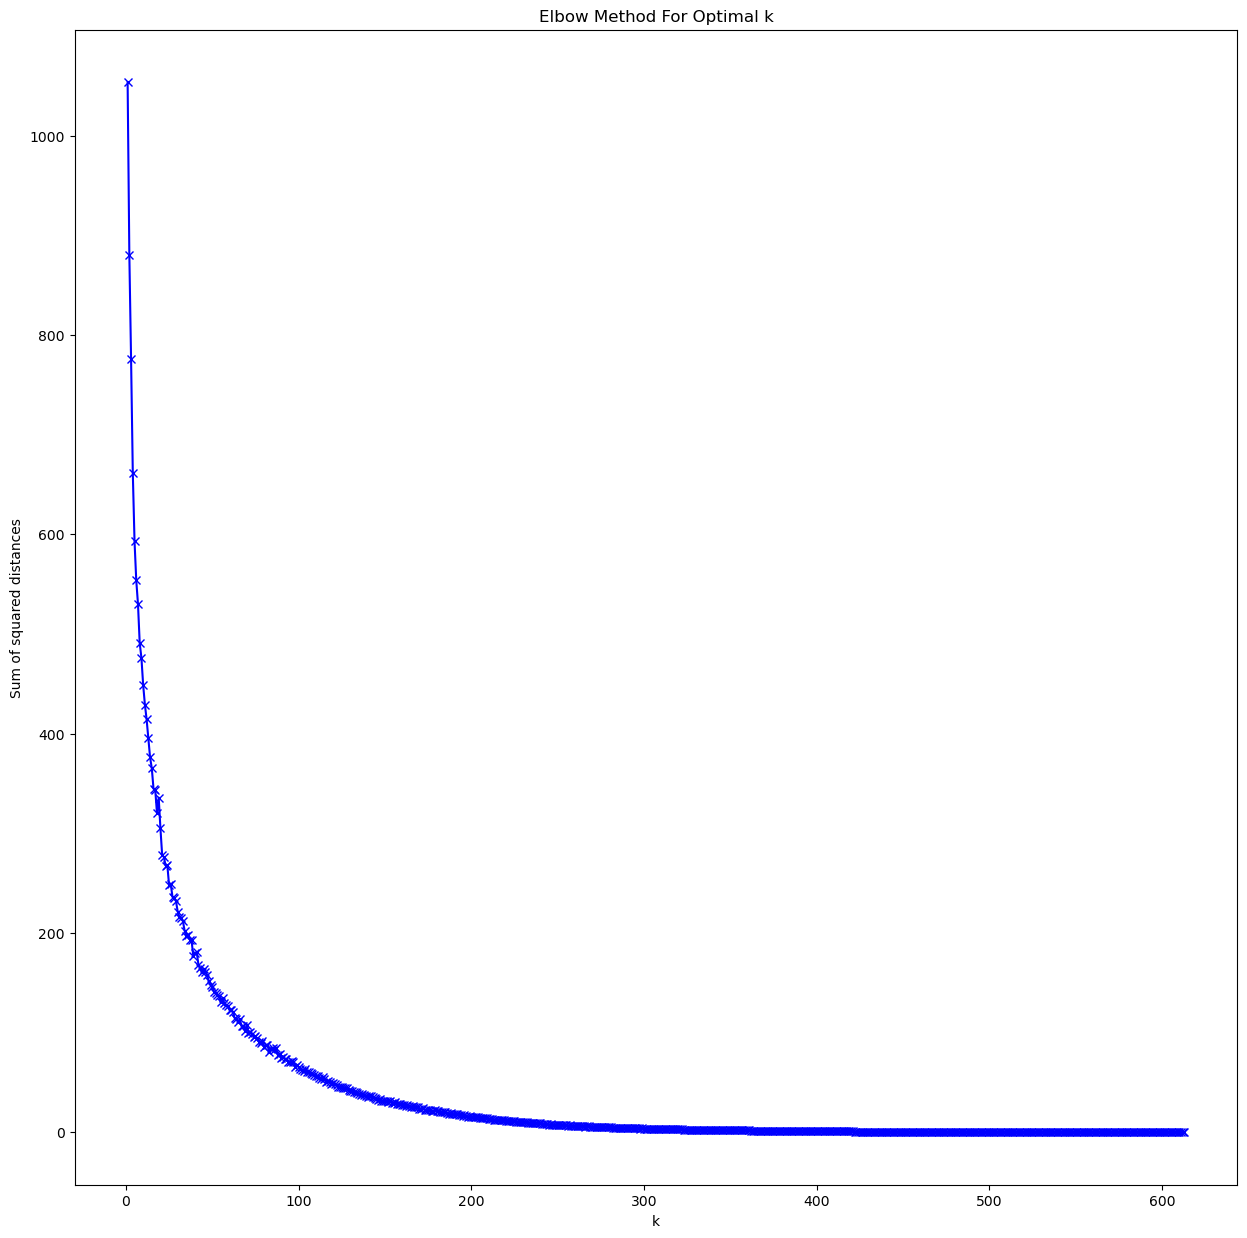

In [14]:
# Plot the sum of squared distances
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(k_range, sum_of_squared_distances, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('Sum of squared distances')
ax.set_title('Elbow Method For Optimal k')
plt.show()

In [15]:
# Define the range of k values to consider
k_range = range(2, len(data_transformed))

# Initialize an empty list to store the silhouette scores for each value of k
silhouette_scores = []

# Iterate over each value of k
for k in k_range:
    # Create a KMeans instance with k clusters, a fixed random state, and automatic initialization
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')

    # Fit the KMeans model to the data and obtain the cluster labels
    labels = km.fit_predict(data_transformed)

    # Calculate the silhouette score for the fitted model and append it to the list
    silhouette_scores.append(silhouette_score(data_transformed, labels))

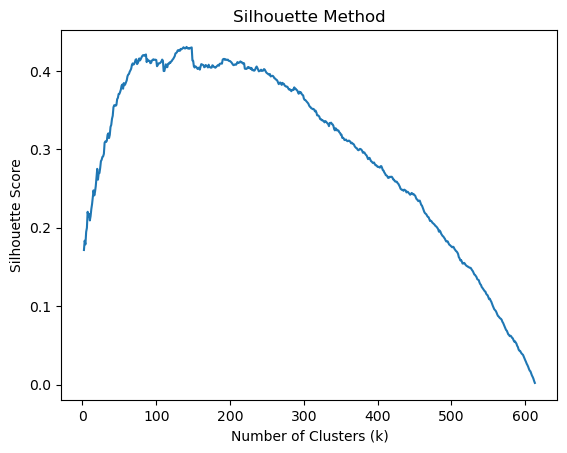

Optimal number of clusters: 141


In [16]:
# Plot the silhouette scores against the number of clusters (k)
plt.plot(k_range, silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Find the optimal value of k
# Optimal value of k is the value with the largest 
# Silhouette score.
optimal_k = k_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_k)

In [17]:
# Set k to the optimal value found using the Silhouette Score.
# This optimal value also seems to align with my elbow graph.
k = optimal_k

In [18]:
# Create a KMeans object with k clusters, 10 initializations, and a maximum of 300 iterations per initialization
clustered_data_sklearn = KMeans(n_clusters=k, n_init=10, max_iter=300)

# Apply the KMeans algorithm to the transformed data and fit the resulting model
clustered_data_sklearn.fit(data_transformed)

KMeans(n_clusters=141, n_init=10)

In [20]:
# Combine the transformed data and cluster centers into a single array along the first axis using np.r_
data_and_centers = np.r_[data_transformed,clustered_data_sklearn.cluster_centers_]

In [26]:
# Create an MDS object with 2 output dimensions and automatic normalization of stress
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)

# Print a message indicating that the transformation is complete
print("transformation complete")

transformation complete


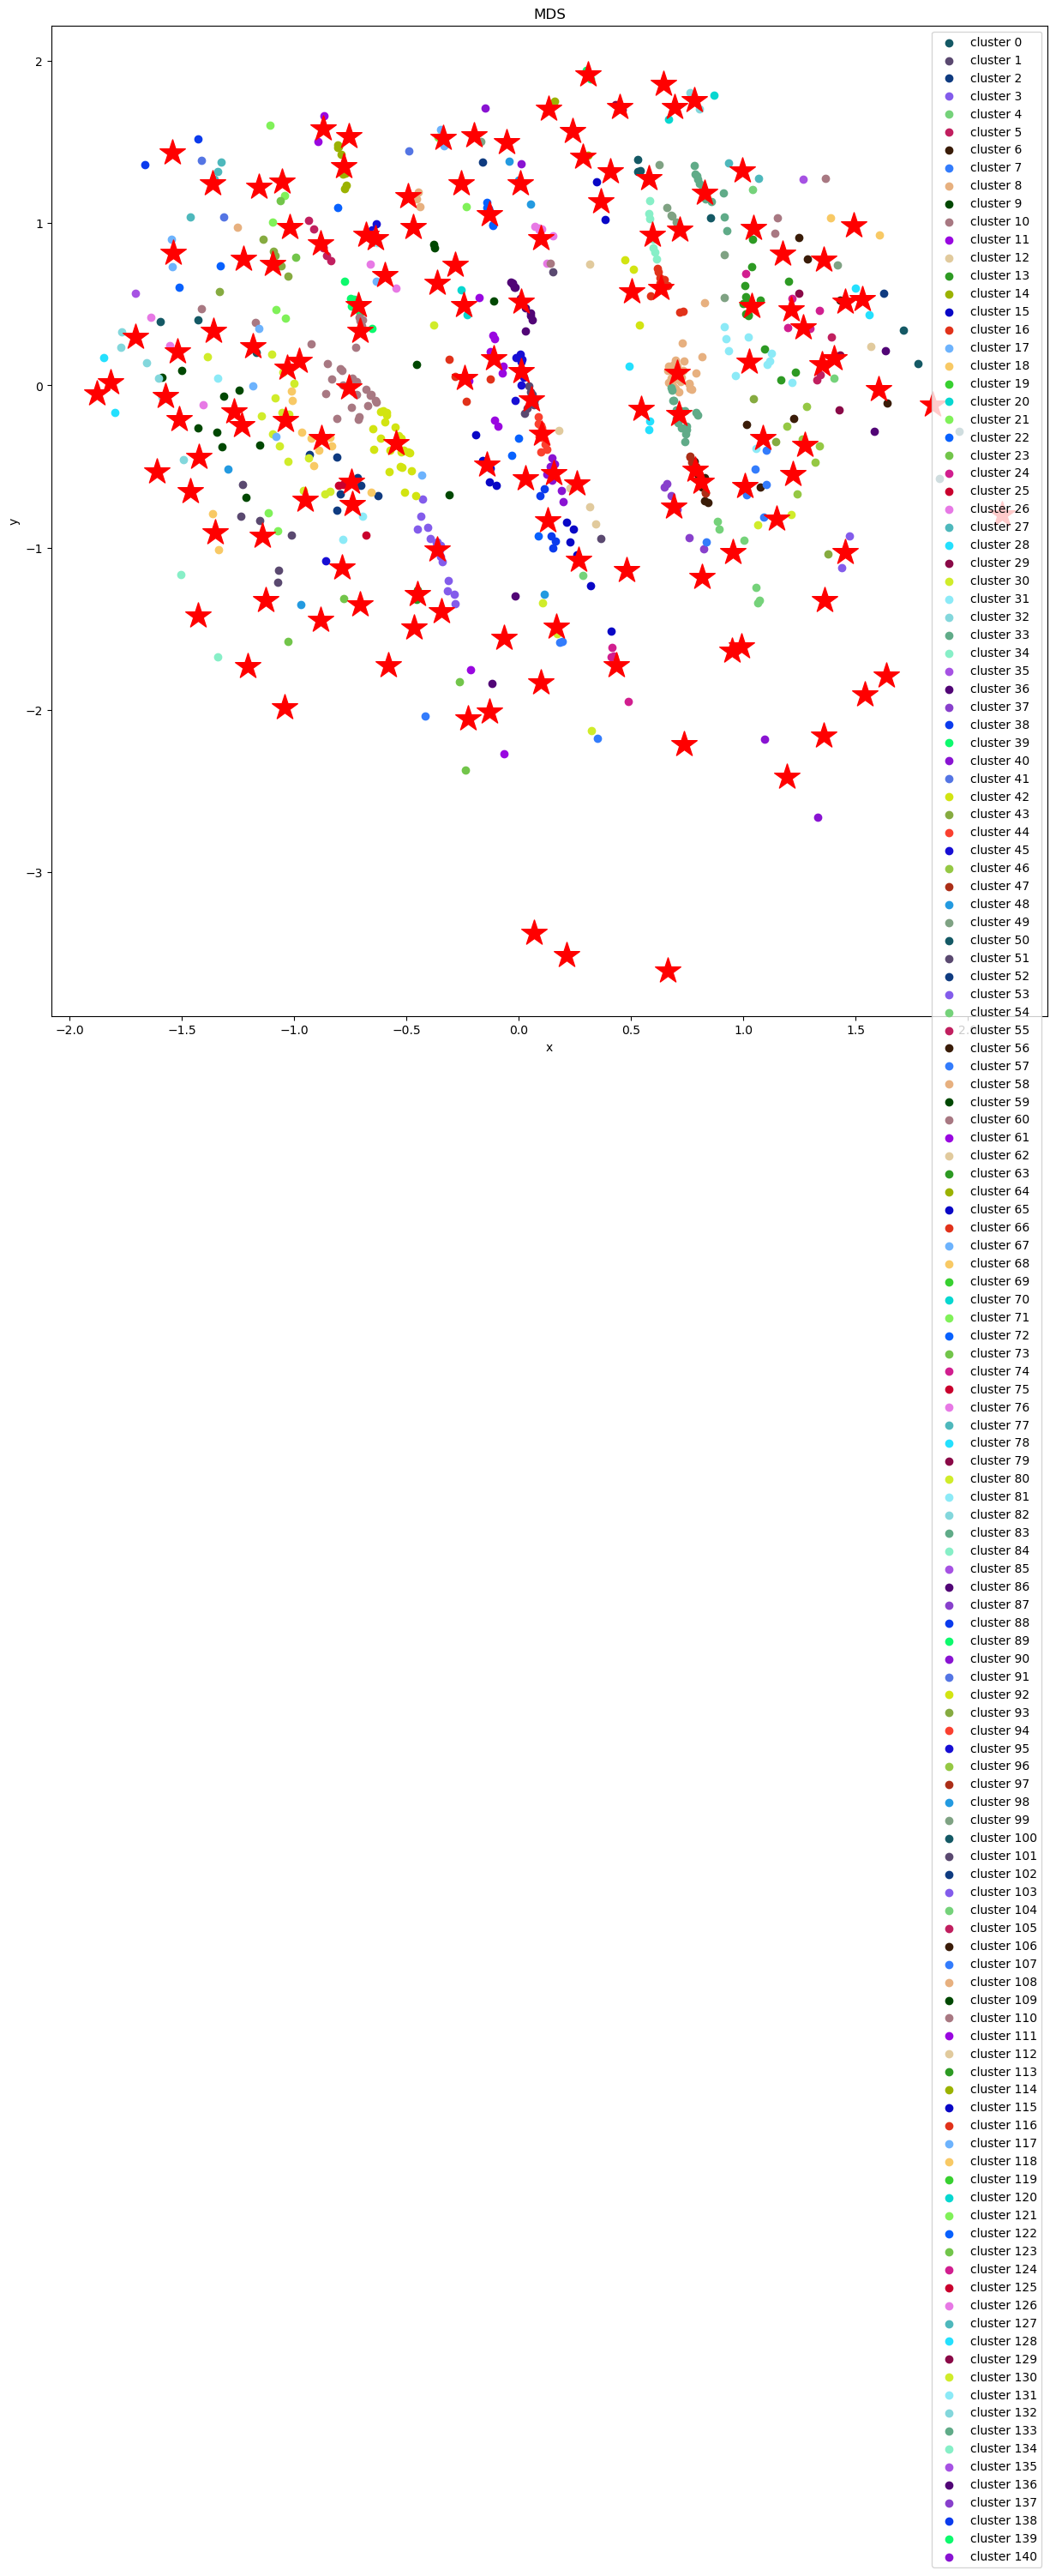

In [27]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

In [28]:
# Create a TSNE object with 2 output dimensions
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


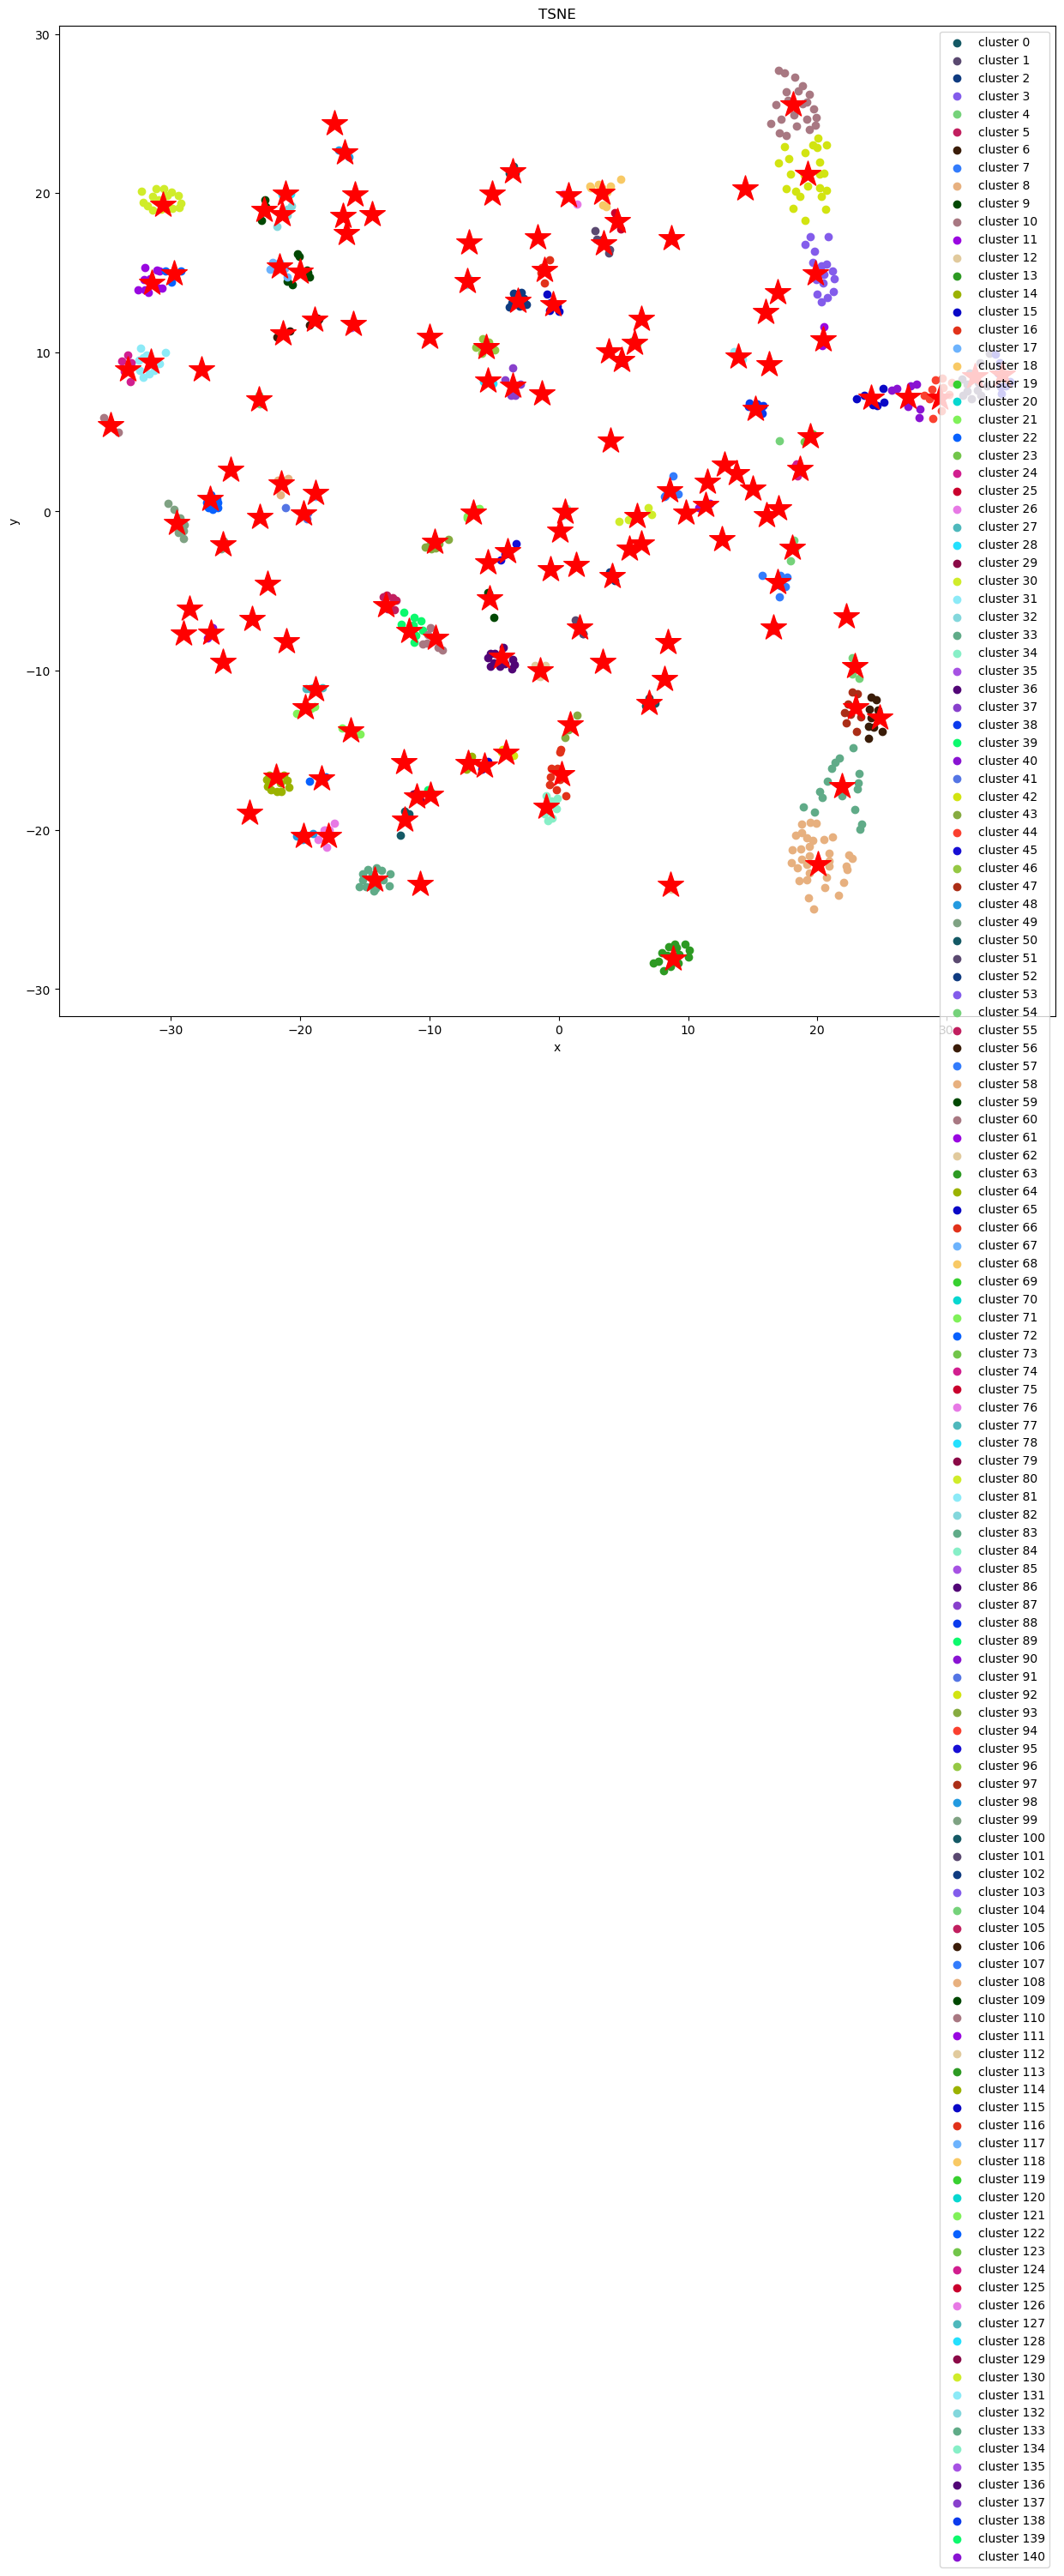

In [29]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')


### Task 3

In [53]:
from sklearn.cluster import DBSCAN

In [54]:
#data_std = scaler.fit_transform(data)

# Create DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN
dbscan.fit(data)

# Print the cluster labels
print(dbscan.labels_)


[ 0 -1 -1  1  0 -1  1 -1  2 -1  2 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  2 -1 -1
 -1 -1  3  1 -1 -1 -1  4 -1  3 -1  2 -1  5 -1  6  4  0  2  3 -1  7  2  2
 -1  8 -1  8 -1 17 -1  3  3 -1  2  1  2  2 -1  9 -1 -1 -1  2 -1 -1  2 -1
 10 -1 -1  4 -1 -1 -1 -1  8 -1 -1 -1  2 10 11  3  0  3  3  3  1 10 -1 -1
  5  3 11  3  1 10 -1  3 -1  2  2 -1 -1 11  0 -1 -1 -1 -1 -1  5  2 -1 -1
 12  8 -1  3 16 13 -1 14 -1 -1 -1  0 10 -1 10 -1 -1 -1 -1 -1 -1  0 -1  3
  2  5 -1 -1 -1  3 -1 -1 -1 -1  0 -1 12  2 -1  3 11 -1 -1 12 -1 12 -1 12
 -1  3 -1 -1 -1  3 -1 12 12 -1  3 -1 -1 -1  3 -1  5 -1 -1 12 -1 12 15 -1
 -1 10 14 -1 -1 -1  5 -1 11 -1 -1  1 11 -1  7 15  0 -1 -1 -1 -1 -1  2 11
 -1  3 -1 -1 -1  3 10  3  3 -1 -1  3 -1 -1  3 -1 15 -1  3 12 -1 -1 13  3
 -1 -1 -1 -1 11 -1  2  1  3  2 -1 -1 -1 -1 -1 -1 -1 17 -1 -1  2 10 -1 13
 -1 14  3 -1 -1  7  7  2 14  3  3  3  3  2 -1 -1 -1  3  2  7 -1 14 -1 12
  8 -1 12 -1  2 -1  3 -1  3 -1 -1 -1 -1 11 13  2 14 -1 13 -1 -1 -1  8  6
 13 -1 -1  1  3  2  8 -1  3  3 16 13 -1 -1 -1 -1 -1

### Spectral

In [58]:

from sklearn.cluster import SpectralClustering

In [60]:
# Create a spectral clustering object
spectral = SpectralClustering(n_clusters=3, affinity='rbf')

# Fit and predict using the spectral clustering object
labels = spectral.fit_predict(data)

# Print the cluster labels
print(labels)

[0 1 0 2 1 1 0 1 0 0 0 0 2 2 0 1 1 0 2 1 1 2 2 1 0 0 0 0 1 0 1 1 2 1 1 1 2
 1 1 0 1 1 1 1 2 1 2 2 2 0 2 1 0 0 0 1 2 1 1 2 1 0 2 0 2 1 1 1 0 0 2 2 0 2
 1 1 0 0 0 0 1 2 0 0 0 1 2 0 1 1 2 0 1 0 0 0 0 2 2 0]
